In [7]:
%matplotlib inline
%load_ext autoreload
%autoreload 2



import matplotlib.pyplot as plt 
import sys
# sys.path.append("../")
from LSTM_Net import LSTM_Net 
import torch 
import torch.nn as nn 
import numpy as np 
import math 
from scipy.signal import ricker
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
import m8r as sf
from skimage.transform import resize
import matplotlib as mlp
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
### 
np.random.seed(1)
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

opath = './Fig/'


scale='minmax'


hsz=50    # hidden size
LR = 0.007 # learning rate
num_layer = 2
model = LSTM_Net(input_size=11, hidden_layer_size=hsz, output_size=1,batch_sz=1,num_layer=num_layer) # model with (feature input,hidden_size,feature output, batch size)
model.load_state_dict(torch.load('./lstm_model_10samples.pth'))
model.cuda()
model.eval()


wav = ricker(50,5)
wav2= ricker(50,3)
wav3= ricker(100,6)
wav4= ricker(200,6)

x = np.concatenate((wav,0.5*wav2,-0.3*wav3,0.8*wav,-0.5*wav4),axis=0)
y = np.concatenate((x,0.3*wav4,0.6*wav3),axis=0)
x = np.concatenate((x,0.3*0.2*wav4,0.6*wav3),axis=0)

# Ideally 
x0 = np.pad(x, (60,90), 'constant', constant_values=(0, 0))
y0 = np.pad(y, (60,90), 'constant', constant_values=(0, 0)) 
diff_true = y0-x0



# Shifted 
x = np.pad(x, (50,100), 'constant', constant_values=(0, 0))
y = np.pad(y, (60,90), 'constant', constant_values=(0, 0)) *0.75

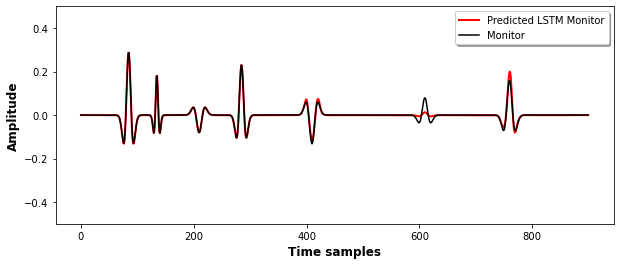

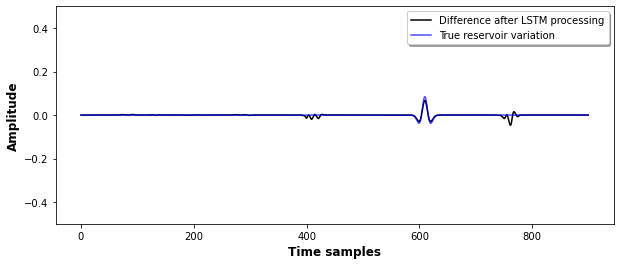

In [39]:
# # Apply the learned network 




x = x.reshape((-1,1))
y = y.reshape((-1,1))


if scale == 'minmax':
        scalerx= MinMaxScaler((-1,1))
        scalerx.fit(x)
        x_sc = scalerx.transform(x)
        scalery= MinMaxScaler((-1,1))
        scalery.fit(y)
        y_sc = scalery.transform(y)

elif scale== 'standard': 
        scalerx= StandardScaler()
        scalerx.fit(x)
        x_sc = scalerx.transform(x)
        scalery= StandardScaler()
        scalery.fit(y)
        y_sc = scalery.transform(y)


x_sc = torch.from_numpy(x_sc).float()
y_sc = torch.from_numpy(y_sc).float()




def window (x,dimension=-1,size=11,step=1):
    ''' x has to be pytorch tensor'''
    return x.unfold(dimension,size,step)


x_sc =window(x_sc,dimension=0,size=11,step=1)
y_sc =window(y_sc,dimension=0,size=11,step=1)[:,:,5]
y_sc = y_sc.view(y_sc.shape[0],y_sc.shape[1],-1)



inp = x_sc.view(1,x_sc.shape[0],-1).cuda()


y_pred = model(inp)
y_pred = y_pred.cpu().detach().numpy()

y_pred = y_pred.reshape((-1,1))
y_pred = scalery.inverse_transform(y_pred)

y_pred1 = np.zeros_like(y)
y_pred1[5:-5] =  y_pred
y_pred = y_pred1

diff_pred = y[:] - y_pred[:]


plt.figure(figsize=(10,4))
plt.plot(y_pred,color='red',linewidth=2,label='Predicted LSTM Monitor')
plt.plot(y[:],color='black',label='Monitor')
plt.xlabel('Time samples',fontsize=12,fontweight='heavy')
plt.ylabel('Amplitude',fontsize=12,fontweight='heavy')
plt.legend(fontsize=10,shadow=True)
plt.ylim(-.5,.5)
plt.savefig(opath+'trace_LSTM_predicted_10samples')

plt.figure(figsize=(10,4))
plt.plot(diff_pred,label='Difference after LSTM processing',color='black')
plt.plot(diff_true,label='True reservoir variation',color='b',alpha=0.7)
plt.xlabel('Time samples',fontsize=12,fontweight='heavy')
plt.ylabel('Amplitude',fontsize=12,fontweight='heavy')
plt.legend(fontsize=10,shadow=True)
plt.ylim(-.5,.5)
plt.savefig(opath+'Difference_after_lstm_10samples')


# plt.savefig(opath+'trace_difference_2')

(900, 1)

# Matching filter 

In [40]:
from time import sleep
import numpy as np
import matplotlib
import warnings
import pylops
warnings.filterwarnings("ignore")


from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.optimization.leastsquares import *
# from pylops.utils.wavelets import ricker
from pylops.utils.signalprocessing import *

## Matching data

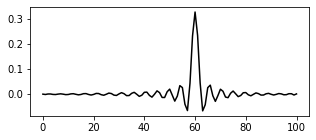

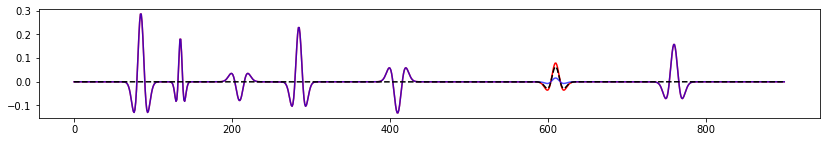

In [41]:
nh = 101 # size of matching filter
wavc = 50 # center of matching filter

x = x.ravel()
y=y.ravel()
# Estimate matching filter from x to y on the first 300 samples
Cop = MatrixMult(convmtx(x[:301], nh)[wavc:-nh+wavc+1])
hmatch = lsqr(Cop, y[:301], iter_lim=100, damp=1e-10)[0]
#hmatch = Cop / y1

# Apply the matching filter to all the data 

Cop_full = MatrixMult(convmtx(x, nh)[wavc:-nh+wavc+1])
y_Mpred = Cop_full @ hmatch

plt.figure(figsize=(5, 2))
plt.plot(hmatch, 'k')

plt.figure(figsize=(14, 2))
plt.plot(y, 'r')
plt.plot(y_Mpred, 'b',alpha=0.7)
plt.plot(y-y_Mpred, '--k')
# plt.xlim(575, 650);

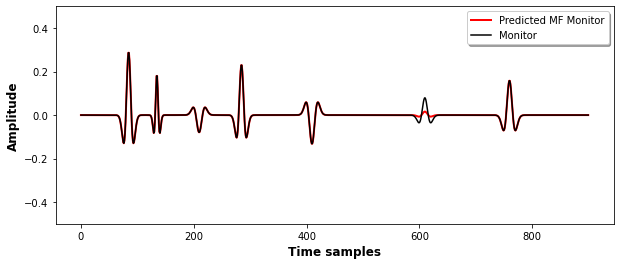

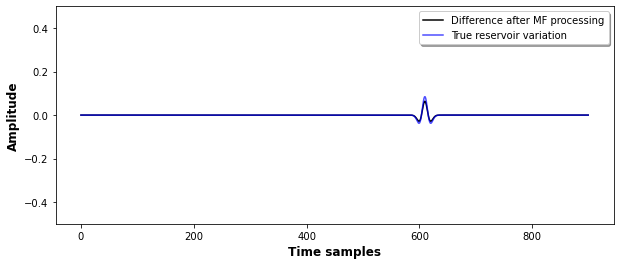

In [12]:
# plt.figure(figsize=(10,4))
# plt.plot(y_Mpred,color='red',linewidth=2,label='Predicted MF Monitor')
# plt.plot(y,color='black',label='Monitor')
# plt.xlabel('Time samples',fontsize=12,fontweight='heavy')
# plt.ylabel('Amplitude',fontsize=12,fontweight='heavy')
# plt.legend(fontsize=10,shadow=True)
# plt.ylim(-.5,.5)
# plt.savefig(opath+'trace_MF_predicted_')


# plt.figure(figsize=(10,4))
# plt.plot(y[:]-y_Mpred[:],label='Difference after MF processing',color='black')
# plt.plot(diff_true,label='True reservoir variation',color='b',alpha=0.7)
# plt.xlabel('Time samples',fontsize=12,fontweight='heavy')
# plt.ylabel('Amplitude',fontsize=12,fontweight='heavy')
# plt.legend(fontsize=10,shadow=True)
# plt.ylim(-.5,.5)
# plt.savefig(opath+'Difference_after_MF')

## Plott All 

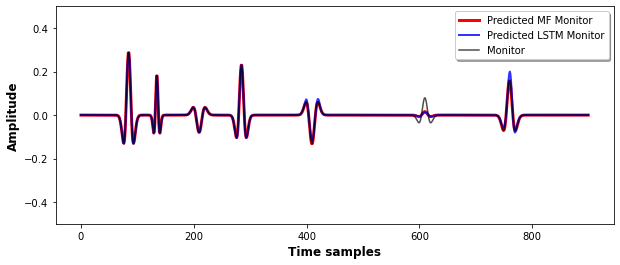

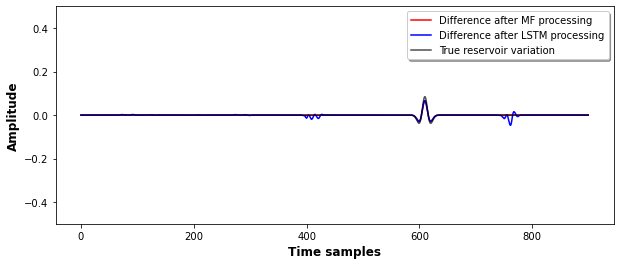

In [42]:



plt.figure(figsize=(10,4))
plt.plot(y_Mpred,color='red',linewidth=3,label='Predicted MF Monitor')
plt.plot(y_pred,color='b',linewidth=2,label='Predicted LSTM Monitor',alpha=0.8)
plt.plot(y,color='black',label='Monitor',alpha=0.7)
plt.xlabel('Time samples',fontsize=12,fontweight='heavy')
plt.ylabel('Amplitude',fontsize=12,fontweight='heavy')
plt.legend(fontsize=10,shadow=True)
plt.ylim(-.5,.5)
plt.savefig(opath+'trace_all_predicted_10samples')


plt.figure(figsize=(10,4))
plt.plot(y[:]-y_Mpred[:],label='Difference after MF processing',color='r')
plt.plot(y[:]-y_pred[:].ravel(),label='Difference after LSTM processing',color='b')
plt.plot(diff_true,label='True reservoir variation',color='k',alpha=0.7)
plt.xlabel('Time samples',fontsize=12,fontweight='heavy')
plt.ylabel('Amplitude',fontsize=12,fontweight='heavy')
plt.legend(fontsize=10,shadow=True)
plt.ylim(-.5,.5)
plt.savefig(opath+'Difference_after_all_10samples')

# Adding noise 